# Simulate Lightcurve

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
from   scipy.interpolate import UnivariateSpline
import astropy
from   astropy.io import fits as pyfits
from   sklearn.cluster import KMeans

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json
from   copy import deepcopy

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import theano
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# LCIT and SCIT in [1/days]
lcit = LCIT/60/24
scit = SCIT/3600/24

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE

In [2]:
# select mission, target, and paths
SIM_ID = "S01478"
PRIMARY_DIR  = '/Users/research/projects/alderaan/'

KOI_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
SIM_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog_eccentric.csv"

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--sim_id", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--sim_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing simulated planet parameters")
    parser.add_argument("--koi_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing real (measured) planet parameters")


    args = parser.parse_args()
    SIM_ID       = args.sim_id
    PRIMARY_DIR  = args.primary_dir
    SIM_FILE     = args.sim_file    
    KOI_FILE     = args.koi_file    
    
except:
    pass

usage: ipykernel_launcher.py [-h] --sim_id SIM_ID --primary_dir PRIMARY_DIR
                             --sim_file SIM_FILE --koi_file KOI_FILE
ipykernel_launcher.py: error: the following arguments are required: --sim_id, --primary_dir, --sim_file, --koi_file


# Make sure the necessary paths exist

In [4]:
# directory in which to find/store inputs/outputs
MAST_DIR = PRIMARY_DIR + 'MAST_downloads/'
SIM_DIR  = PRIMARY_DIR + 'Simulations/' 

# check if all the paths exist and create them if not
if os.path.exists(SIM_DIR + 'Lightcurves/') == False:
    os.mkdir(SIM_DIR + 'Lightcurves/')
    
if os.path.exists(SIM_DIR + "Lightcurves/Kepler/") == False:
    os.mkdir(SIM_DIR + "Lightcurves/Kepler/")

# Read in star and planet parameters for REAL KOIs

In [5]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
KOI_ID = "K" + SIM_ID[1:]
csv_keys, csv_values = io.read_csv_file(KOI_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

RSTAR = np.array(target_dict['rstar'], dtype='float')[use]
MSTAR = np.array(target_dict['mstar'], dtype='float')[use]

U1 = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2 = np.array(target_dict['limbdark_2'], dtype='float')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> [unitless]
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
IMPACTS = np.array(target_dict['impact'], dtype='float')[use]

Reading in data from csv file


In [6]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file') 
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')
    
if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [7]:
# limb darkening coefficients
UCOEFFS = [U1, U2]

# Read in Holczer data

In [8]:
HOLCZER_FILE = PRIMARY_DIR + "Catalogs/holczer_2016_kepler_ttvs.txt"

holczer_data = np.loadtxt(HOLCZER_FILE, usecols=[0,1,2,3])

holczer_inds = []
holczer_tts  = []
holczer_pers = []

for npl in range(NPL):
    koi = int(KOI_ID[1:]) + 0.01*(1+npl)
    use = np.isclose(holczer_data[:,0], koi, rtol=1e-10, atol=1e-10)

    # Holczer uses BJD -24548900; BJKD = BJD - 2454833
    if np.sum(use) > 0:
        holczer_inds.append(np.array(holczer_data[use,1], dtype="int"))
        holczer_tts.append(holczer_data[use,2] + holczer_data[use,3]/24/60 + 67)
        holczer_pers.append(np.median(holczer_tts[npl][1:] - holczer_tts[npl][:-1]))

    else:
        holczer_inds.append(None)
        holczer_tts.append(None)
        holczer_pers.append(np.nan)

holczer_pers = np.asarray(holczer_pers)

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [9]:
# short cadence
try:
    sc_path  = glob.glob(MAST_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
    sc_files = glob.glob(sc_path + '*')

    sc_rawdata_list = []
    for i, scf in enumerate(sc_files):
        oscfi = lk.search.open(sc_files[i])
        sc_rawdata_list.append(oscfi)

    sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
    sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

    sc_quarters = []
    for i, scd in enumerate(sc_data):
        sc_quarters.append(scd.quarter)

except:
    sc_data = []
    sc_quarters = []


# long cadence data
lc_path  = glob.glob(MAST_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
lc_files = glob.glob(lc_path + '*')

lc_rawdata_list = []
for i, lcf in enumerate(lc_files):
    olcfi = lk.search.open(lc_files[i])

    if ~np.isin(olcfi.quarter, sc_quarters):
        lc_rawdata_list.append(olcfi)

lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)

lc_quarters = []
for i, lcd in enumerate(lc_data):
    lc_quarters.append(lcd.quarter)

In [10]:
# determine the time baseline
time_min = []
time_max = []

try:
    for i, scd in enumerate(sc_data):
        time_min.append(scd.time.min())
        time_max.append(scd.time.max())
        
except:
    pass


try:
    for i, lcd in enumerate(lc_data):
        time_min.append(lcd.time.min())
        time_max.append(lcd.time.max())
        
except:
    pass
    
    
TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

if TIME_START < 0:
    raise ValueError("START TIME [BKJD] is negative...this will cause problems")


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [11]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = IMPACTS[npl]           
    p.radius   = np.sqrt(p.depth*RSTAR)*RSRE
        
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)

    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 1 Planet objects


# Check if Holczer TTVs exist, and if so, replace the linear ephemeris

In [12]:
for npl in range(NPL):
    match = np.isclose(holczer_pers, p.period, rtol=0.1, atol=DURS.max())
    
    if np.sum(match) > 1:
        raise ValueError("Something has gone wrong matching periods between DR25 and Holczer+ 2016")
        
    if np.sum(match) == 1:
        loc = np.squeeze(np.where(match))
    
        hinds = holczer_inds[loc]
        htts  = holczer_tts[loc]
        
        for i, t0 in enumerate(p.tts):
            for j, tH in enumerate(htts):
                if np.abs(t0-tH)/p.period < 0.25:
                    p.tts[i] = tH

# Model and remove known transits

WARNING (theano.gof.cmodule): Deleting (broken cache directory [EOF]): /Users/research/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.3-64/tmpwkzhlvhn


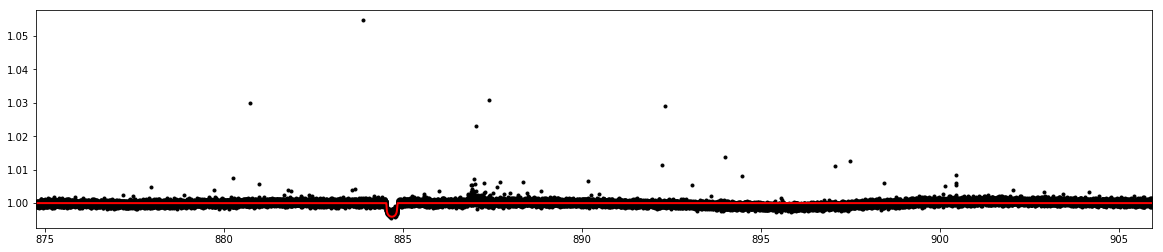

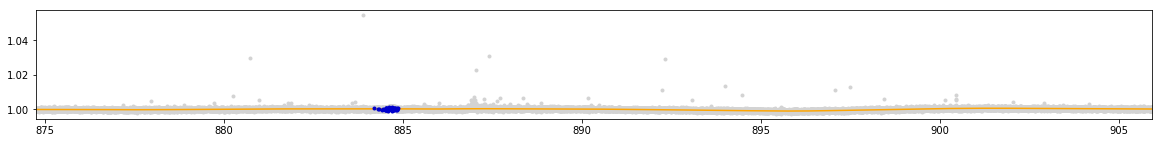

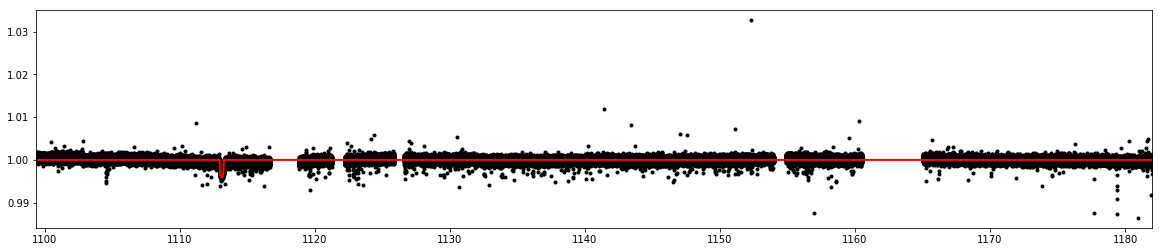

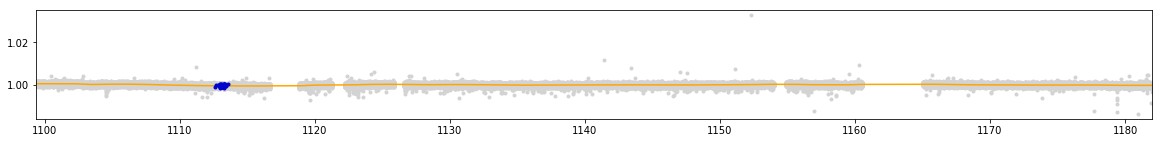

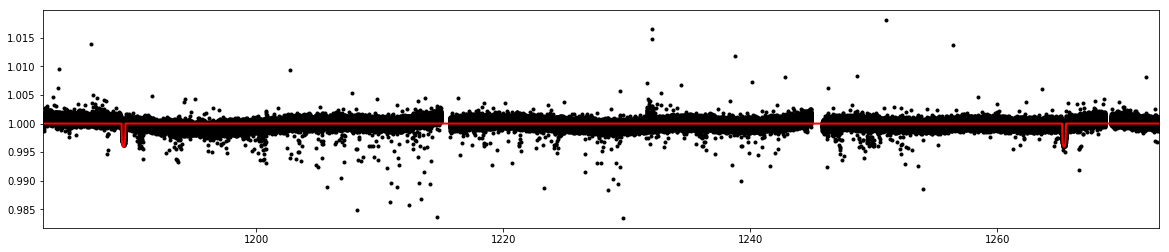

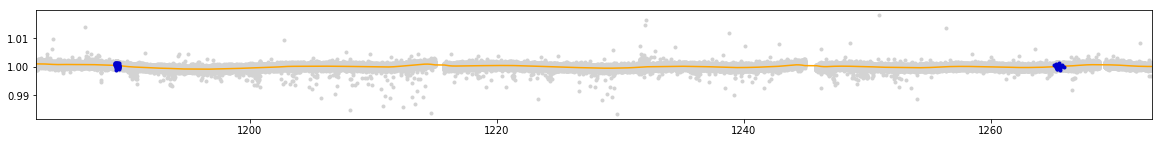

In [13]:
for i, scd in enumerate(sc_data):
    tmin = scd.time.min()
    tmax = scd.time.max()
    
    xtime = np.array(scd.time, dtype="float64")
    yflux = np.array(scd.flux, dtype="float64")
    
    
    # grab the transit times that are found in this quarter
    transit_times = []
    transit_inds  = []
    
    radii = []
    impacts = []
    periods = []
    
    for npl, p in enumerate(planets):
        use = (p.tts > tmin)*(p.tts < tmax)
        
        if np.sum(use) > 0:
            transit_times.append(p.tts[use])
            transit_inds.append(np.arange(np.sum(use), dtype="int"))
        
            radii.append(p.radius/RSRE)
            impacts.append(p.impact)
            periods.append(p.period)
            
    
    # model the transits
    if len(transit_times) > 0:
        exoSLC = exo.StarryLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, period=periods,
                                     b=impacts, r_star=RSTAR, m_star=MSTAR)


        light_curves = exoSLC.get_light_curve(orbit=orbit, r=radii, t=xtime, oversample=1)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()
    
    else:
        model_flux = np.ones_like(yflux)
    

    # check that transits were properly removed
    mask = np.zeros_like(sc_data[i].time)

    for npl, p in enumerate(planets):
        for t0 in p.tts:
            mask += np.abs(xtime - t0)/p.duration < 1.5

    mask = mask > 0
    
    yclean = yflux/model_flux
    
    npts = 1+60*int(3*DURS.max()*24)
    ytrend = boxcar_smooth(ndimage.median_filter(yclean, size=npts), winsize=npts)
        
    out = np.abs(yclean-ytrend)/astropy.stats.mad_std(yclean-ytrend) > 3.0
    out[~mask] = False
    
    yclean[out] = ytrend[out] + np.random.normal(size=np.sum(out))*astropy.stats.mad_std(yclean-ytrend)
    
    
    # save the cleaned lightcurve
    sc_data[i].flux = np.copy(yclean)

    
    plt.figure(figsize=(20,4))
    plt.plot(xtime, yflux, "k.")
    plt.plot(xtime, model_flux, c="red", lw=2)
    plt.xlim(xtime.min(), xtime.max())
    plt.show()
    
    plt.figure(figsize=(20,2))
    plt.plot(xtime, yclean, ".", c="lightgrey")
    plt.plot(xtime, ytrend, "orange")
    plt.plot(xtime[out], yclean[out], ".", c="mediumblue")
    plt.xlim(xtime.min(), xtime.max())
    plt.show()

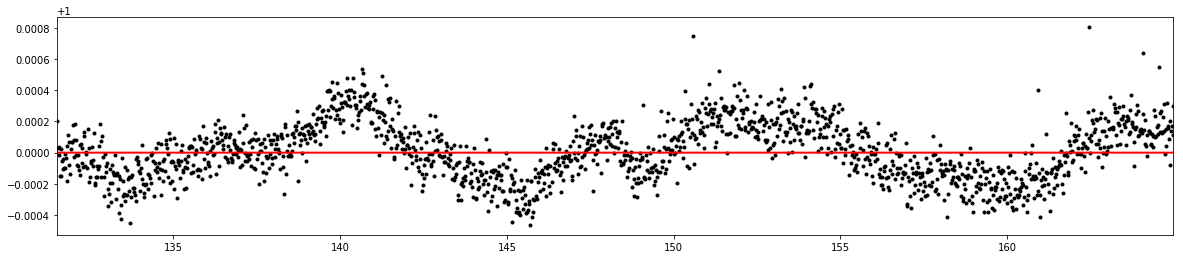

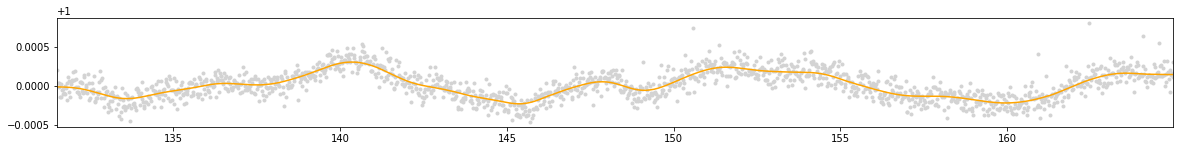

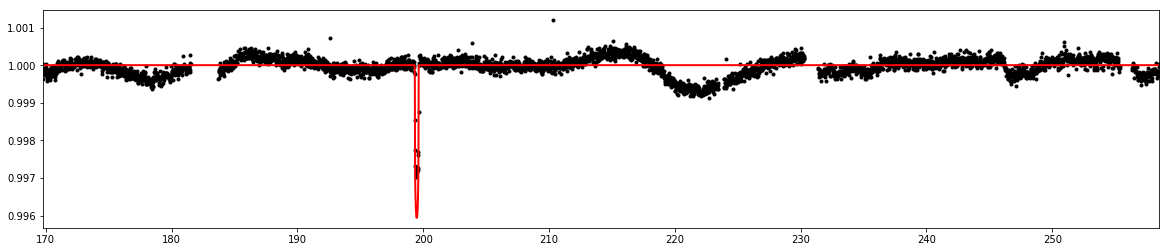

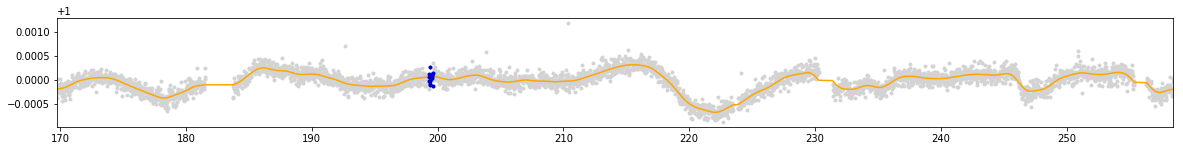

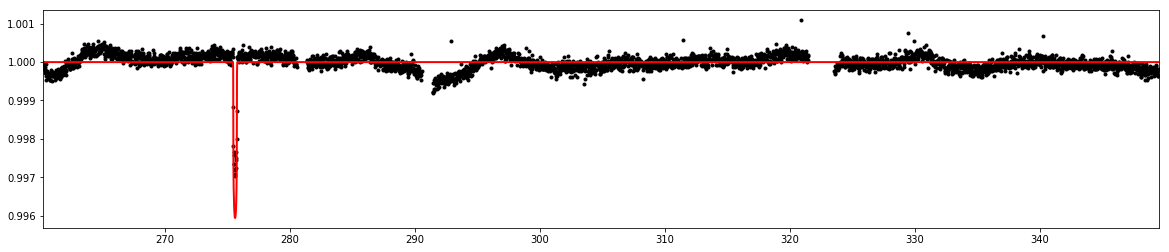

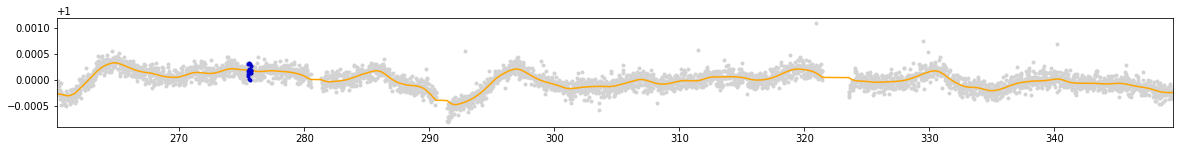

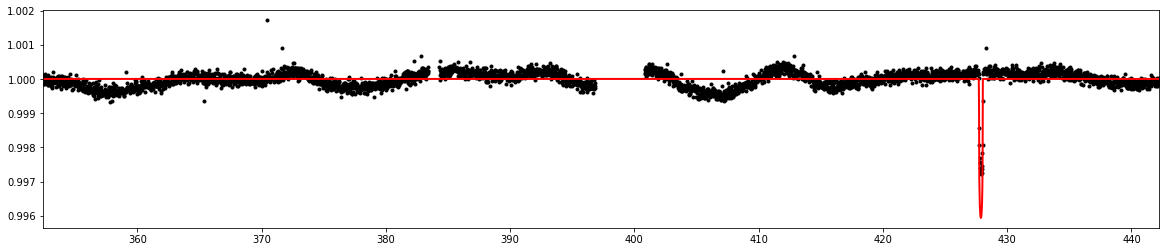

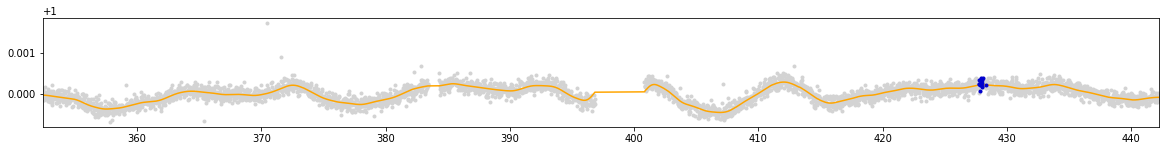

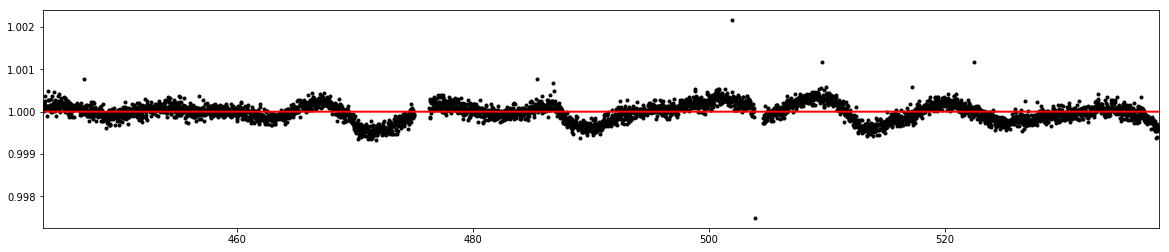

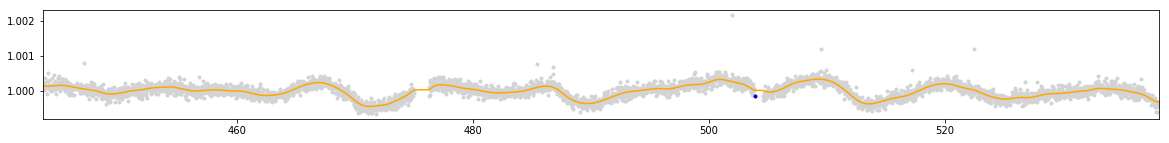

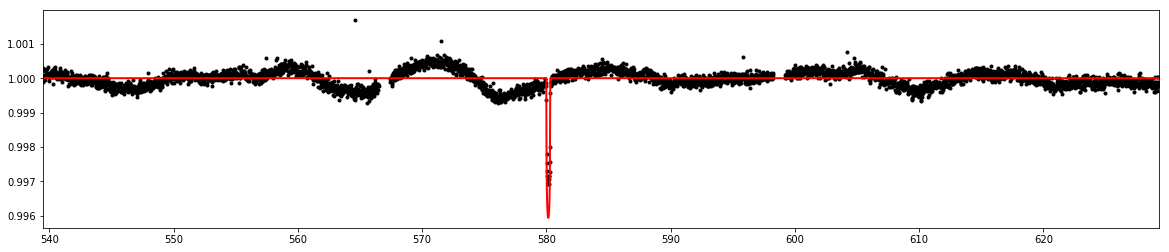

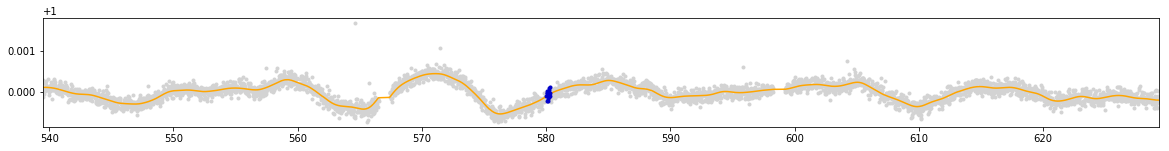

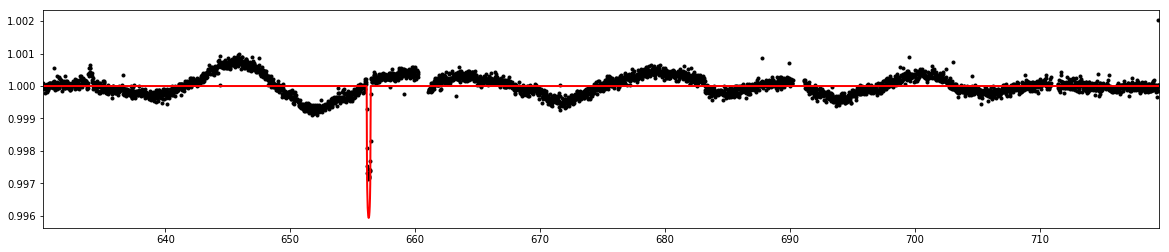

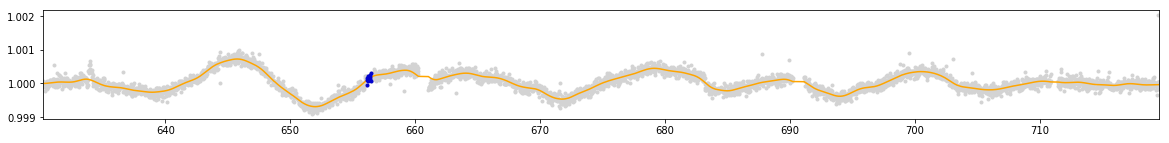

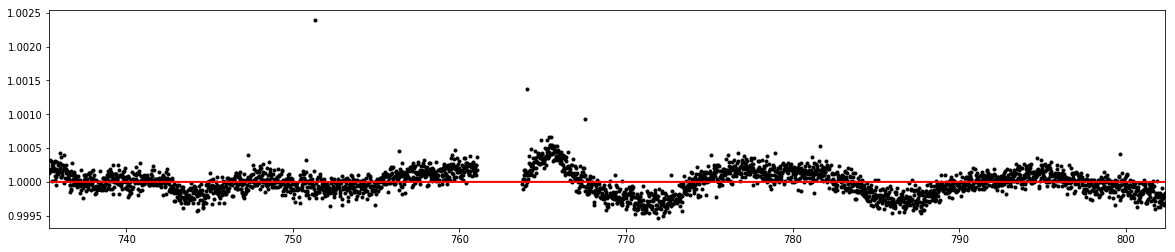

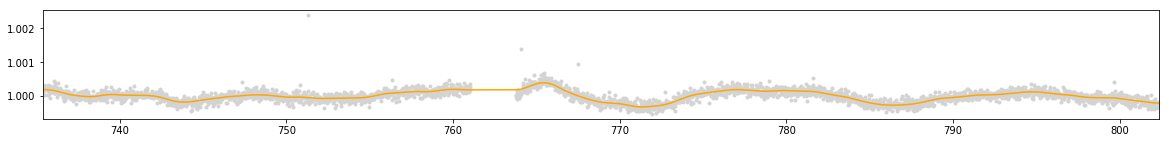

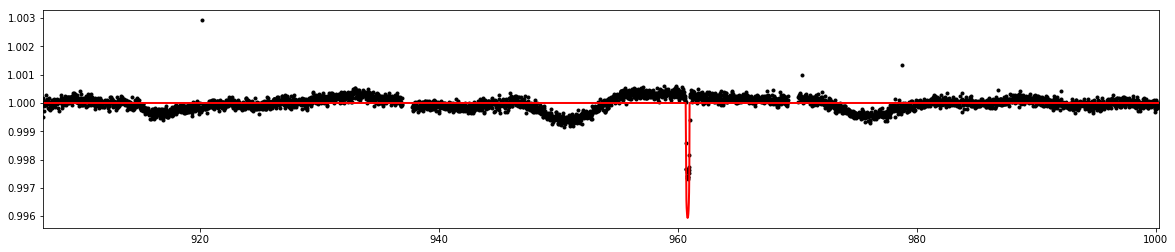

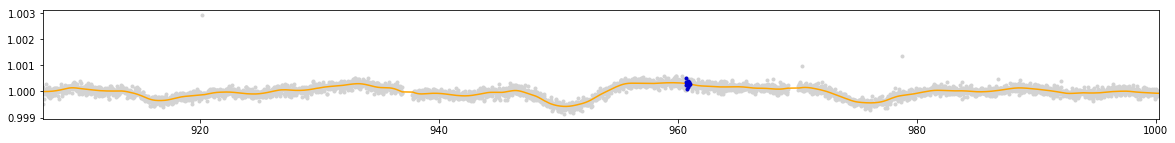

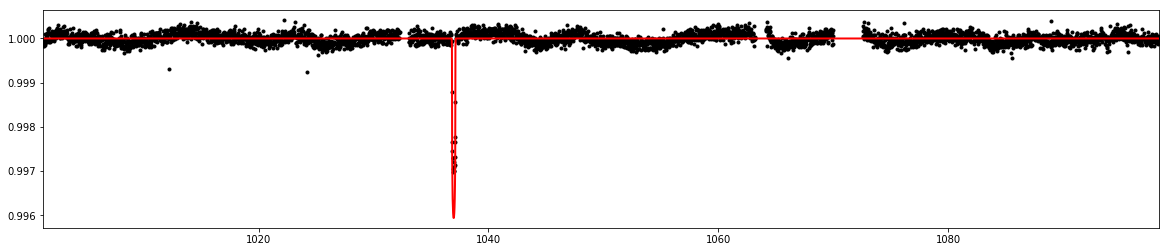

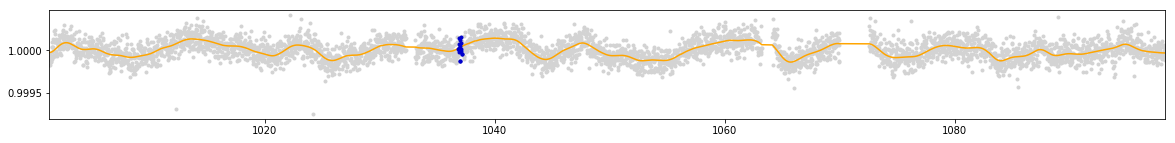

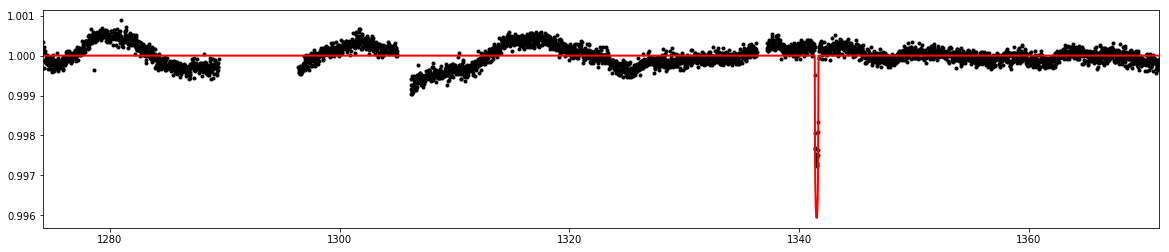

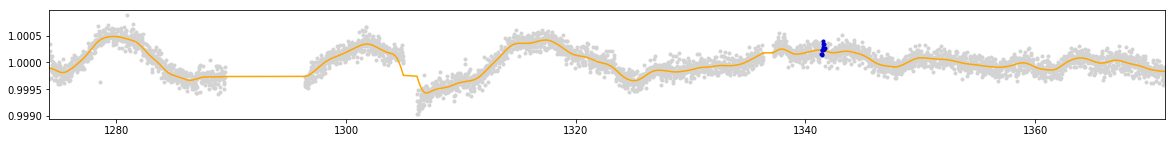

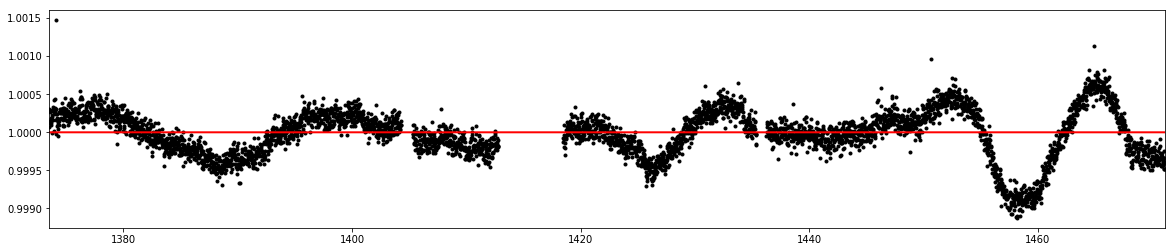

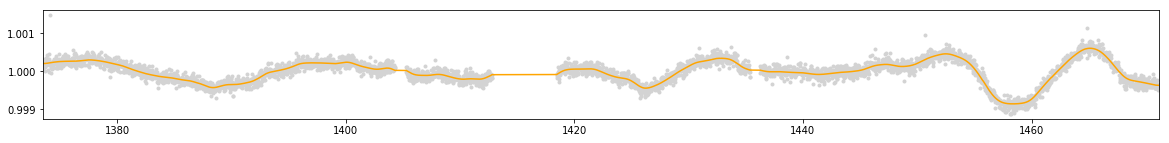

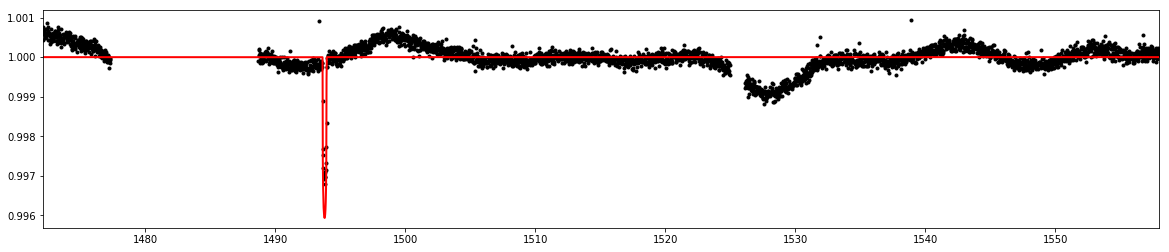

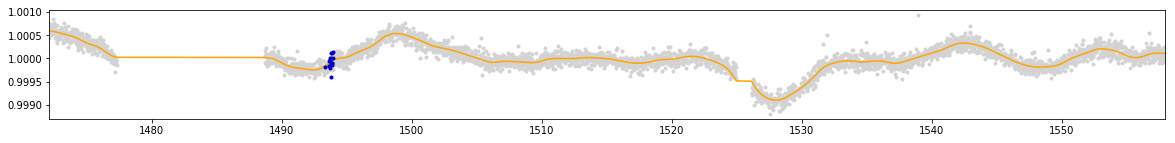

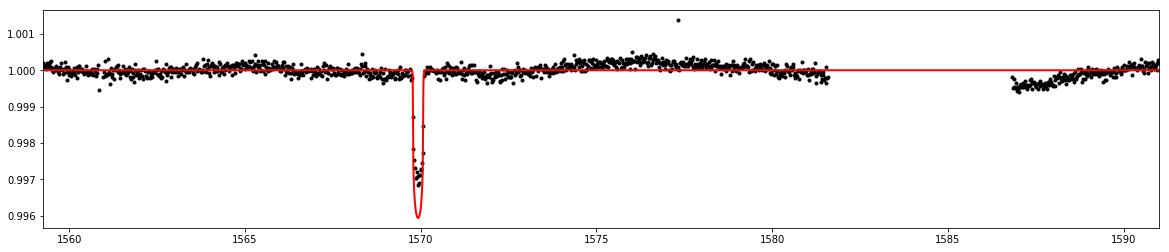

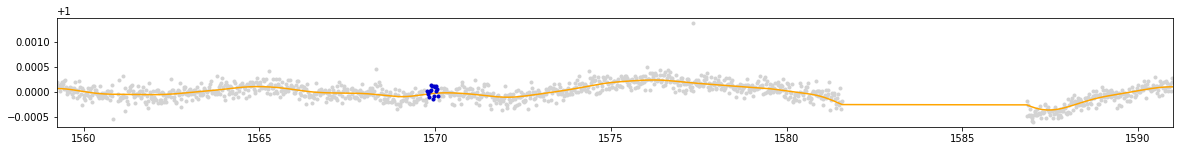

In [14]:
for i, lcd in enumerate(lc_data):
    tmin = lcd.time.min()
    tmax = lcd.time.max()
    
    xtime = np.array(lcd.time, dtype="float64")
    yflux = np.array(lcd.flux, dtype="float64")
    
    
    # grab the transit times that are found in this quarter
    transit_times = []
    transit_inds  = []
    
    radii = []
    impacts = []
    periods = []
    
    for npl, p in enumerate(planets):
        use = (p.tts > tmin)*(p.tts < tmax)
        
        if np.sum(use) > 0:
            transit_times.append(p.tts[use])
            transit_inds.append(np.arange(np.sum(use), dtype="int"))
        
            radii.append(p.radius/RSRE)
            impacts.append(p.impact)
            periods.append(p.period)
            
            
    # model the transits
    if len(transit_times) > 0:
        exoSLC = exo.StarryLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, period=periods,
                                     b=impacts, r_star=RSTAR, m_star=MSTAR)

        light_curves = exoSLC.get_light_curve(orbit=orbit, r=radii, t=xtime, oversample=15)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()
    
    
    else:
        model_flux = np.ones_like(yflux)
    
    
    # check that transits were properly removed
    mask = np.zeros_like(lc_data[i].time)

    for npl, p in enumerate(planets):
        for t0 in p.tts:
            mask += np.abs(xtime - t0)/p.duration < 1.5

    mask = mask > 0
    
    yclean = yflux/model_flux
    
    npts = 1+2*int(3*DURS.max()*24)
    ytrend = boxcar_smooth(ndimage.median_filter(yclean, size=npts), winsize=npts)
        
    out = np.abs(yclean-ytrend)/astropy.stats.mad_std(yclean-ytrend) > 3.0
    out[~mask] = False
    
    yclean[out] = ytrend[out] + np.random.normal(size=np.sum(out))*astropy.stats.mad_std(yclean-ytrend)
    
    
    # save the cleaned lightcurve
    lc_data[i].flux = np.copy(yclean)

    
    plt.figure(figsize=(20,4))
    plt.plot(xtime, yflux, "k.")
    plt.plot(xtime, model_flux, c="red", lw=2)
    plt.xlim(xtime.min(), xtime.max())
    plt.show()
    
    plt.figure(figsize=(20,2))
    plt.plot(xtime, yclean, ".", c="lightgrey")
    plt.plot(xtime, ytrend, "orange")
    plt.plot(xtime[out], yclean[out], ".", c="mediumblue")
    plt.xlim(xtime.min(), xtime.max())
    plt.show()

# Read in data for simulated planets

In [15]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(SIM_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

RSTAR = np.array(target_dict['rstar'], dtype='float')[use]
MSTAR = np.array(target_dict['mstar'], dtype='float')[use]

U1 = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2 = np.array(target_dict['limbdark_2'], dtype='float')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> [unitless]
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
IMPACTS = np.array(target_dict['impact'], dtype='float')[use]
RADII   = np.array(target_dict['prad'], dtype='float')[use]
ECCS    = np.array(target_dict['ecc'], dtype='float')[use]
OMEGAS  = np.array(target_dict['omega'], dtype='float')[use]

Reading in data from csv file


In [16]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file') 
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')
    
if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [17]:
# limb darkening coefficients
UCOEFFS = [U1, U2]

# Read in pre-simulated transit times

In [18]:
transit_inds = []
transit_times = []

for npl in range(NPL):

    fname_in = SIM_DIR + "TTVs/" + SIM_ID + "_0{0}_sim_ttvs.txt".format(npl)
    data_in  = np.loadtxt(fname_in).swapaxes(0,1)
    
    transit_inds.append(np.array(data_in[0], dtype="int"))
    transit_times.append(np.array(data_in[1], dtype="float"))

# Initialize new Planet objects

In [19]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = IMPACTS[npl]            
    p.radius   = RADII[npl]
    p.ecc      = ECCS[npl]
    p.omega    = OMEGAS[npl]
    
    # add transit times and indexes
    p.tts = transit_times[npl]
    p.index = transit_inds[npl]
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 1 Planet objects


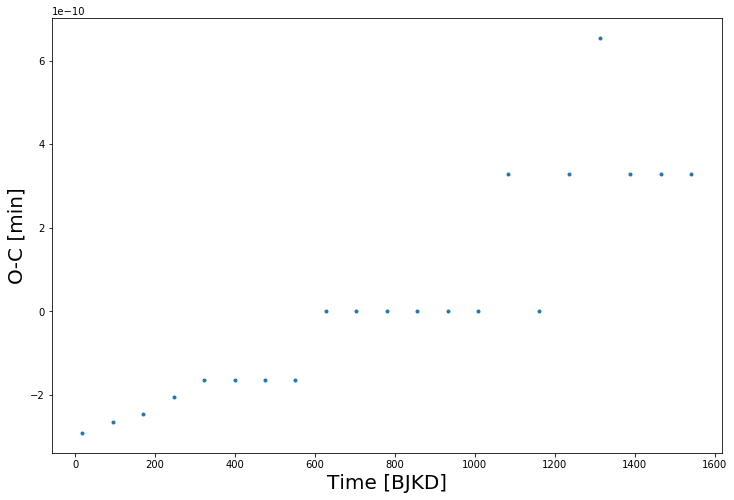

In [20]:
# plot the OMC TTVs
fig, ax = plt.subplots(NPL, figsize=(12,8))
if NPL == 1: ax = [ax]

for npl, p in enumerate(planets):
    xtime = np.polyval(np.polyfit(p.index, p.tts, 1), p.index)
    yomc  = (p.tts - xtime)*24*60
    
    ax[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    ax[npl].set_ylabel('O-C [min]', fontsize=20)
ax[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

# Add synthetic transits to the lighcurve

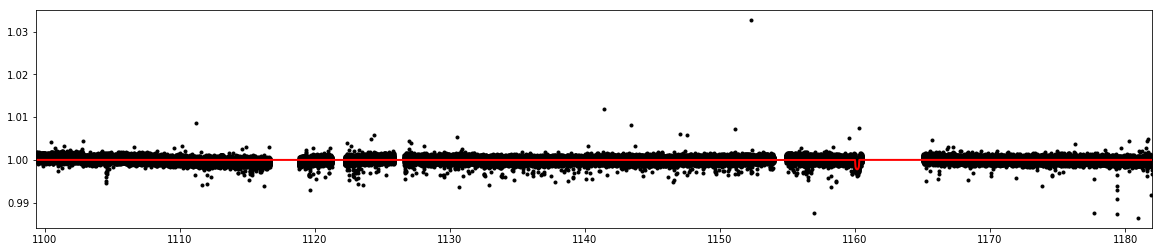

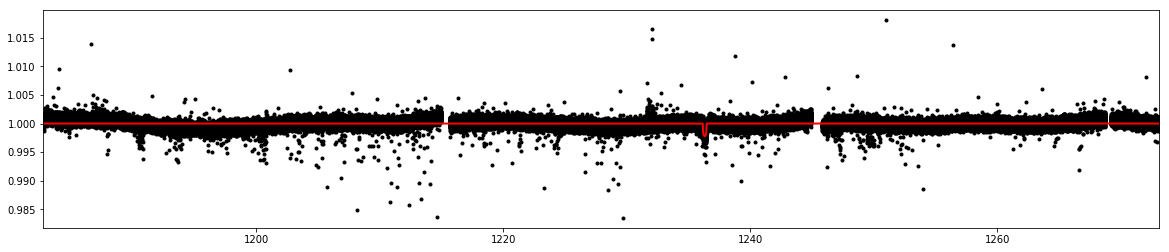

In [21]:
for i, scd in enumerate(sc_data):
    tmin = scd.time.min()
    tmax = scd.time.max()
    
    xtime = np.array(scd.time, dtype="float64")
    yflux = np.array(scd.flux, dtype="float64")
    
    
    # grab the transit times that are found in this quarter
    transit_times = []
    transit_inds  = []
    
    radii = []
    impacts = []
    periods = []
    eccs = []
    omegas = []
    
    for npl, p in enumerate(planets):
        use = (p.tts > tmin)*(p.tts < tmax)
        
        if np.sum(use) > 0:
            transit_times.append(p.tts[use])
            transit_inds.append(p.index[use] - p.index[use].min())
        
            radii.append(p.radius/RSRE)
            impacts.append(p.impact)
            periods.append(p.period)
            eccs.append(p.ecc)
            omegas.append(p.omega)
            
    
    if len(transit_times) > 0:
        exoSLC = exo.StarryLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, period=periods,
                                     b=impacts, ecc=eccs, omega=omegas, r_star=RSTAR, m_star=MSTAR)


        light_curves = exoSLC.get_light_curve(orbit=orbit, r=radii, t=xtime, oversample=1)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()


        sc_data[i].flux = yflux * model_flux


        plt.figure(figsize=(20,4))
        plt.plot(xtime, sc_data[i].flux, "k.")
        plt.plot(xtime, model_flux, c="red", lw=2)
        plt.xlim(xtime.min(), xtime.max())
        plt.show()
        
        
    else:
        sc_data[i].flux = yflux * 1.0

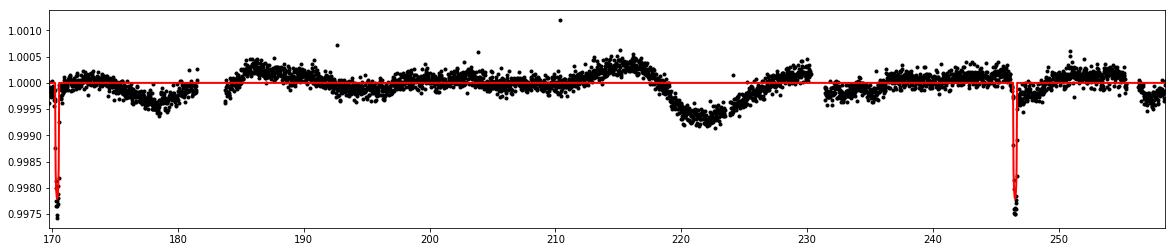

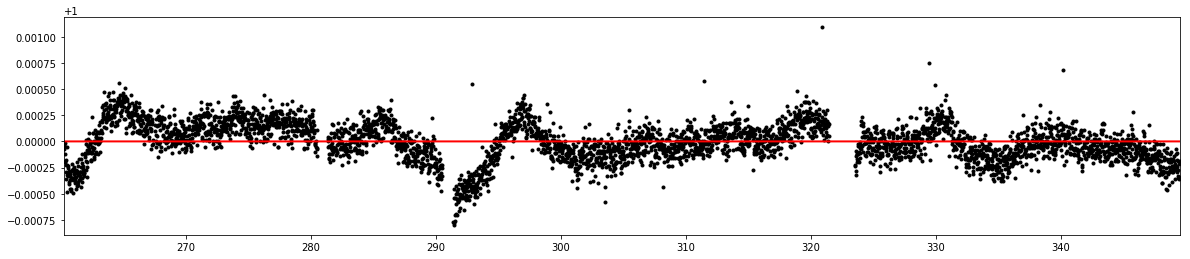

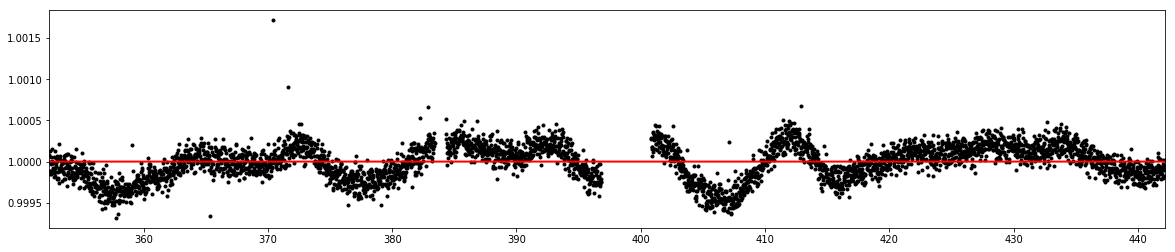

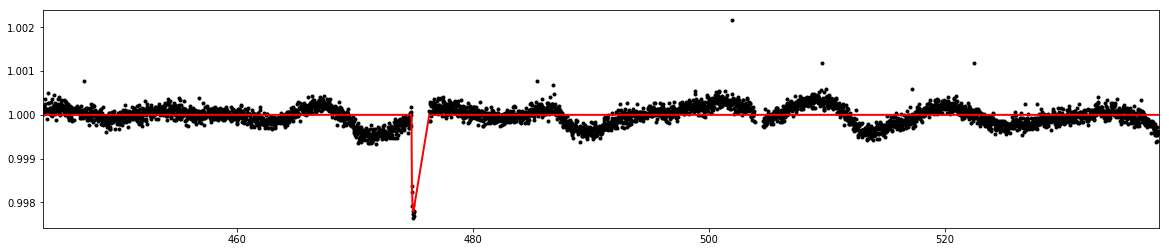

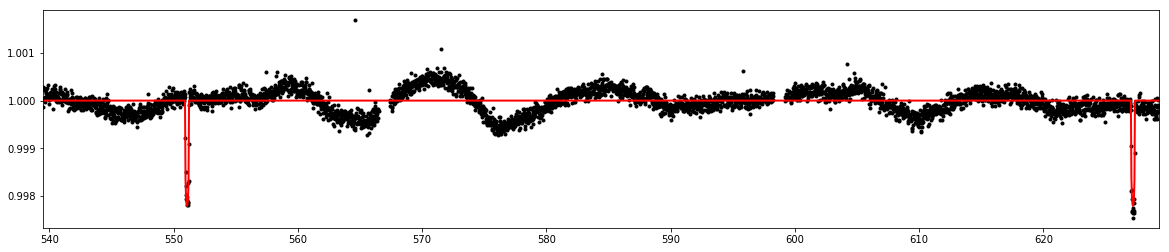

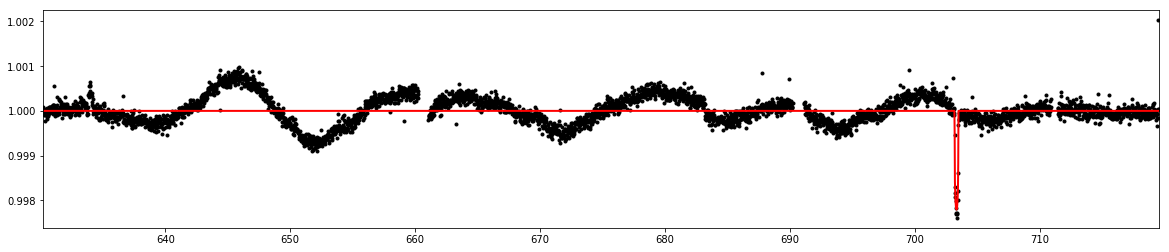

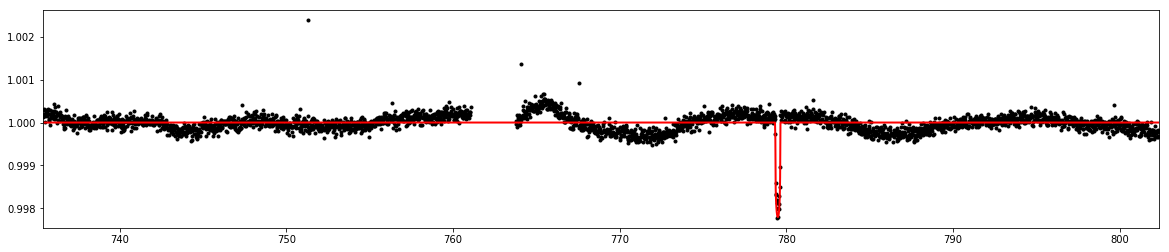

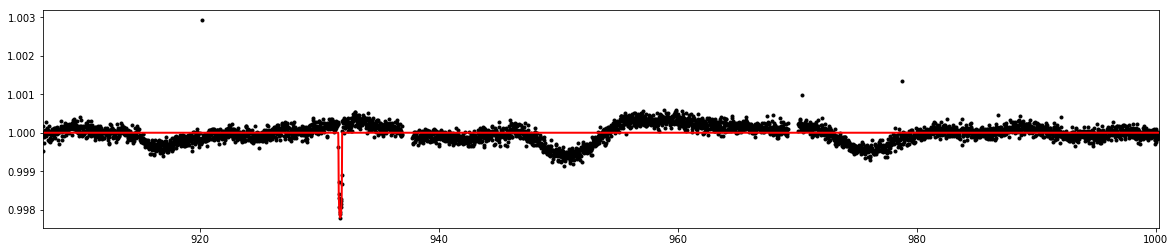

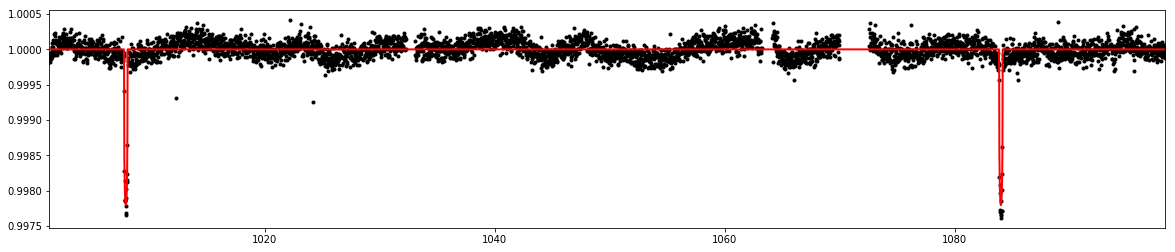

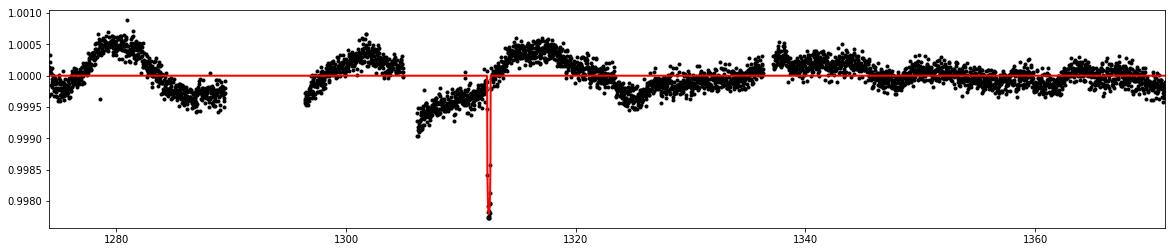

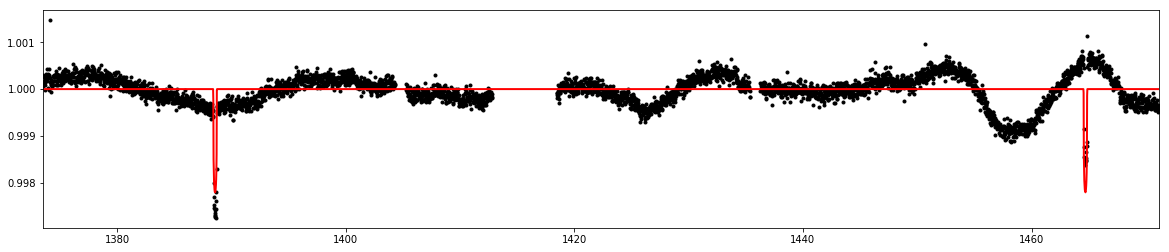

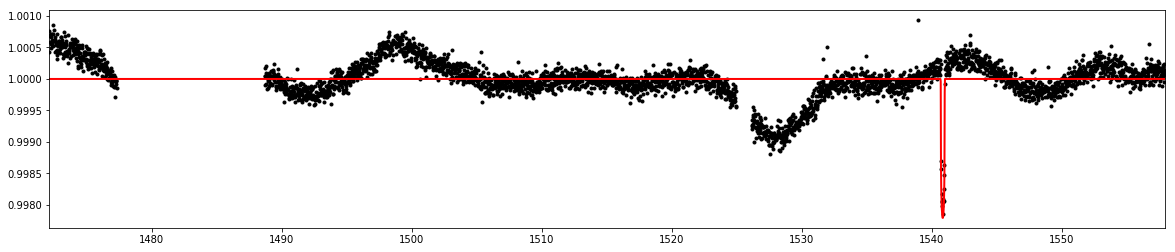

In [22]:
for i, lcd in enumerate(lc_data):
    tmin = lcd.time.min()
    tmax = lcd.time.max()
    
    xtime = np.array(lcd.time, dtype="float64")
    yflux = np.array(lcd.flux, dtype="float64")
    
    
    # grab the transit times that are found in this quarter
    transit_times = []
    transit_inds  = []
    
    radii = []
    impacts = []
    periods = []
    eccs = []
    omegas = []
    
    for npl, p in enumerate(planets):
        use = (p.tts > tmin)*(p.tts < tmax)
        
        if np.sum(use) > 0:
            transit_times.append(p.tts[use])
            transit_inds.append(p.index[use] - p.index[use].min())
        
            radii.append(p.radius/RSRE)
            impacts.append(p.impact)
            periods.append(p.period)
            eccs.append(p.ecc)
            omegas.append(p.omega)
            

    if len(transit_times) > 0:
        exoSLC = exo.StarryLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, period=periods,
                                     b=impacts, ecc=eccs, omega=omegas, r_star=RSTAR, m_star=MSTAR)

        light_curves = exoSLC.get_light_curve(orbit=orbit, r=radii, t=xtime, oversample=15)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()


        lc_data[i].flux = yflux * model_flux


        plt.figure(figsize=(20,4))
        plt.plot(xtime, lc_data[i].flux, "k.")
        plt.plot(xtime, model_flux, c="red", lw=2)
        plt.xlim(xtime.min(), xtime.max())
        plt.show()
        
        
    else:
        lc_data[i].flux = yflux*1.0

# Save the simulated lightcurves

In [23]:
lc_dir = SIM_DIR + "Lightcurves/Kepler/" + "simkplr" + "{0:09d}".format(KIC) + "_lc/"
   
if os.path.exists(lc_dir) == False:
    os.mkdir(lc_dir)

    
for i, lcd in enumerate(lc_data):
    fname_out = lc_dir + "simkplr" + "{0:09d}".format(KIC) + "-q{:02d}_llc.fits".format(lcd.quarter)
    
    io.save_sim_fits(lcd, path=fname_out, overwrite=True)

In [24]:
sc_dir = SIM_DIR + "Lightcurves/Kepler/" + "simkplr" + "{0:09d}".format(KIC) + "_sc/"
print(sc_dir)

if os.path.exists(sc_dir) == False:
    os.mkdir(sc_dir)

    
for i, scd in enumerate(sc_data):
    fname_out = sc_dir + "simkplr" + "{0:09d}".format(KIC) + "-q{:02d}_slc.fits".format(scd.quarter)
    
    io.save_sim_fits(scd, path=fname_out, overwrite=True)

/Users/research/projects/alderaan/Simulations/Lightcurves/Kepler/simkplr012403119_sc/


In [25]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

TOTAL RUNTIME = 23.75 min
